Objetivo deste notebook é analisar as séries temporais de veículos do Brasil

Link dos dados: https://anfavea.com.br/site/edicoes-em-excel/

## Imports

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from statsmodels.tsa.arima.model import ARIMA

## Tratamento dos dados

In [77]:
# Lendo os dados já tratados.

df = pd.read_csv('../data/veiculos/licenciamento_nacionais_2016-2023.csv')
df.set_index(df.data, inplace=True, drop=True)
df.drop("data", axis=1)
df.index = pd.to_datetime(df.index)
df.index = df.index.to_period("M")
index = df.index.to_timestamp()

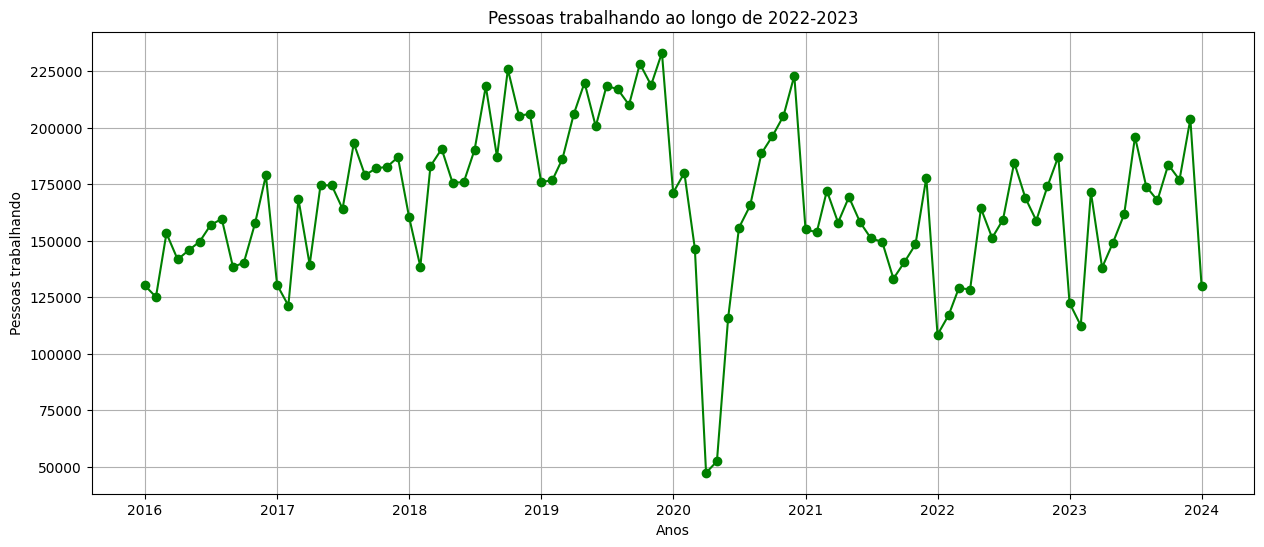

In [78]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the data
ax.plot(index, df['populacao'], marker='o', linestyle='-', color='green')

# Set title and labels
ax.set_title('Pessoas trabalhando ao longo de 2022-2023')
ax.set_xlabel('Anos')
ax.set_ylabel('Pessoas trabalhando')

# Enable grid
ax.grid(True)

# Show plot
plt.show()

## Iniciação da decomposição 

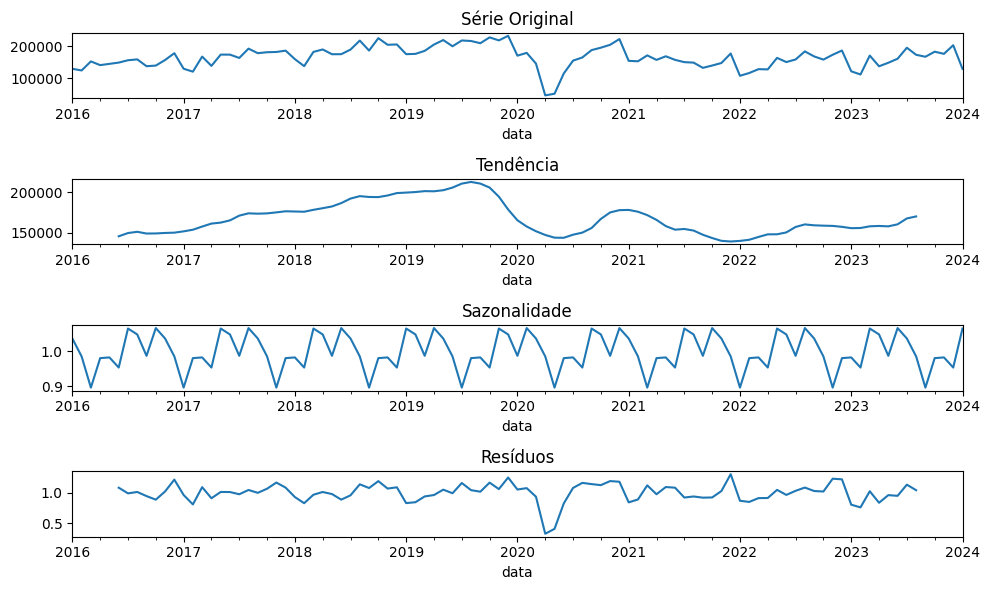

In [79]:
decomposition = seasonal_decompose(df.populacao, model='multiplicative', period=10)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Série Original')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Tendência')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Sazonalidade')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Resíduos')
plt.tight_layout()
plt.show()

###  Série Original: 
Este é o gráfico da série temporal de dados original, mostra as flutuações ao longo do tempo. Podemos observar que existem variações periódicas e alguns picos e vales ao longo da série.

### Tendência
O gráfico de tendência mostra como a série temporal evolui ao longo do tempo, excluindo a sazonalidade e o ruído. Há uma tendência geral de aumento (se anularmos o período da Pandemia que bagunçou tudo), indicando que há um crescimento ou uma tendência ascendente na série ao longo do período observado. 

### Sazonalidade
Este componente revela padrões que se repetem em intervalos regulares. O gráfico da sazonalidade não mostra um padrão claro e repetitivo, sugerindo que a sazonalidade pode não ser um fator significativo na série temporal ou que o período de sazonalidade pode não estar bem capturado.

### Resíduos
Este gráfico mostra o que resta da série temporal após a remoção da tendência e da sazonalidade. Os resíduos representam a flutuação aleatória que não pode ser explicada pelos modelos de tendência ou sazonalidade. O ideal é que os resíduos pareçam ser ruído branco, ou seja, sem padrões discerníveis, o que indicaria que a tendência e a sazonalidade foram bem capturadas nos outros componentes.

## Teste ADF para ver se esta série temporal é estacionária

In [80]:
# Diferenciação

df['diff_populacao'] = df['populacao'].diff().fillna(0)

# Realizando o teste ADF na série temporal 'diff_net_revenue'
adf_test_result_diff = adfuller(df['diff_populacao'])

# Criando um DataFrame para exibir os resultados do teste de forma mais clara
# Incluindo os valores críticos
adf_test_result_diff = pd.DataFrame({
    'Item': [
        'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used',
        'Critical Value (1%)', 'Critical Value (5%)', 'Critical Value (10%)'
    ],
    'Value': [
        adf_test_result_diff[0],  # Test statistic
        adf_test_result_diff[1],  # p-value
        adf_test_result_diff[2],  # #Lags Used
        adf_test_result_diff[3],  # Number of Observations Used
        adf_test_result_diff[4]['1%'],  # Critical Value for 1%
        adf_test_result_diff[4]['5%'],  # Critical Value for 5%
        adf_test_result_diff[4]['10%']  # Critical Value for 10%
    ]
})

adf_test_result_diff

,Item,Value
0,Test Statistic,-3.966976
1,p-value,0.001594
2,#Lags Used,12.000000
3,Number of Observations Used,84.000000
4,Critical Value (1%),-3.510712
5,Critical Value (5%),-2.896616
6,Critical Value (10%),-2.585482


p-value < 0.05 ; logo, é estacionária

Além disso:  CV(1%) > Test Statistic. Logo, a hipótese nula pode ser rejeitada com um nível de confiança de <=95% 

### Como a série possui sazonalidade, usar SARIMAX como modelo de predição.

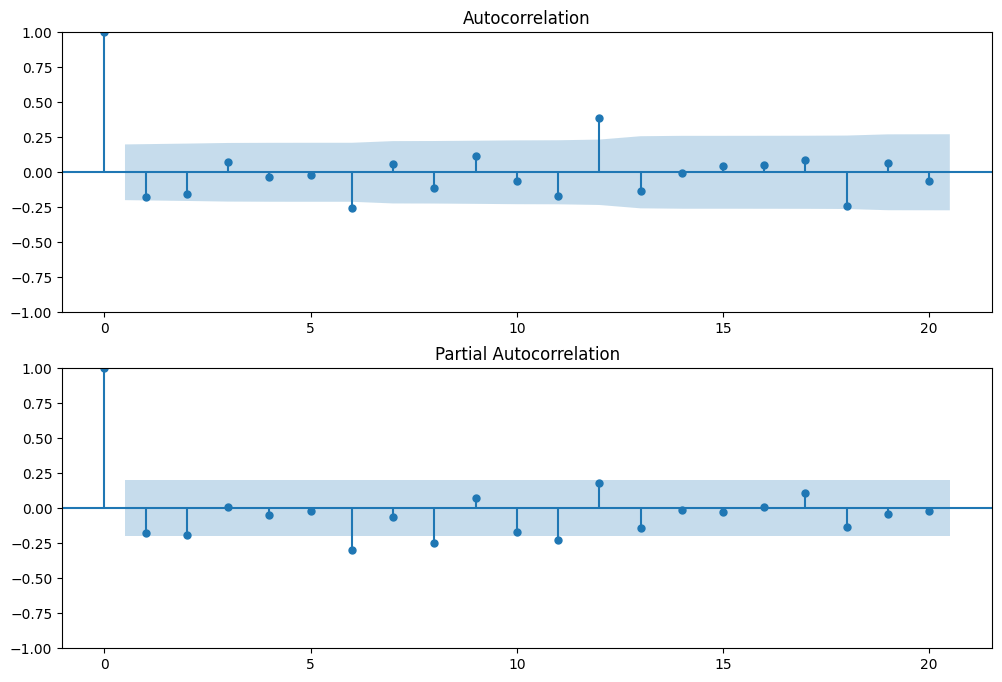

In [81]:
# Plotando ACF e PACF para descobrir os melhores hiperparâmetros do SARIMAX
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrelação
plot_acf(df['diff_populacao'], ax=ax1)

# Autocorrelação Parcial
plot_pacf(df['diff_populacao'], ax=ax2, method='ywm')

plt.show()

In [82]:
p = 1  # ordem do componente autoregressivo
d = 1  # ordem de diferenciação
q = 1  # ordem do componente de média móvel

# Modelo SARIMAX
model = SARIMAX(df['populacao'], order=(p, d, q), seasonal_order=(1, 1, 0, 12))
model_fit = model.fit(disp=False)

## Fazendo a previsão com SARIMAX

In [83]:
# Previsões das datas futuras
future_dates = [index[-1] + DateOffset(weeks=x) for x in range(1, 13)]

# Previsões dos valores
forecast_object = model_fit.get_forecast(steps=12)

# Intervalo de confiança
confianca = forecast_object.conf_int()


# Criando dataset com os valores futuros colhidos
forecast_df = pd.DataFrame({
    #'date': future_dates,
    'populacao': forecast_object.predicted_mean
    #'lower_confidence': confianca.iloc[:, 0],
    #'upper_confidence': confianca.iloc[:, 1]
})

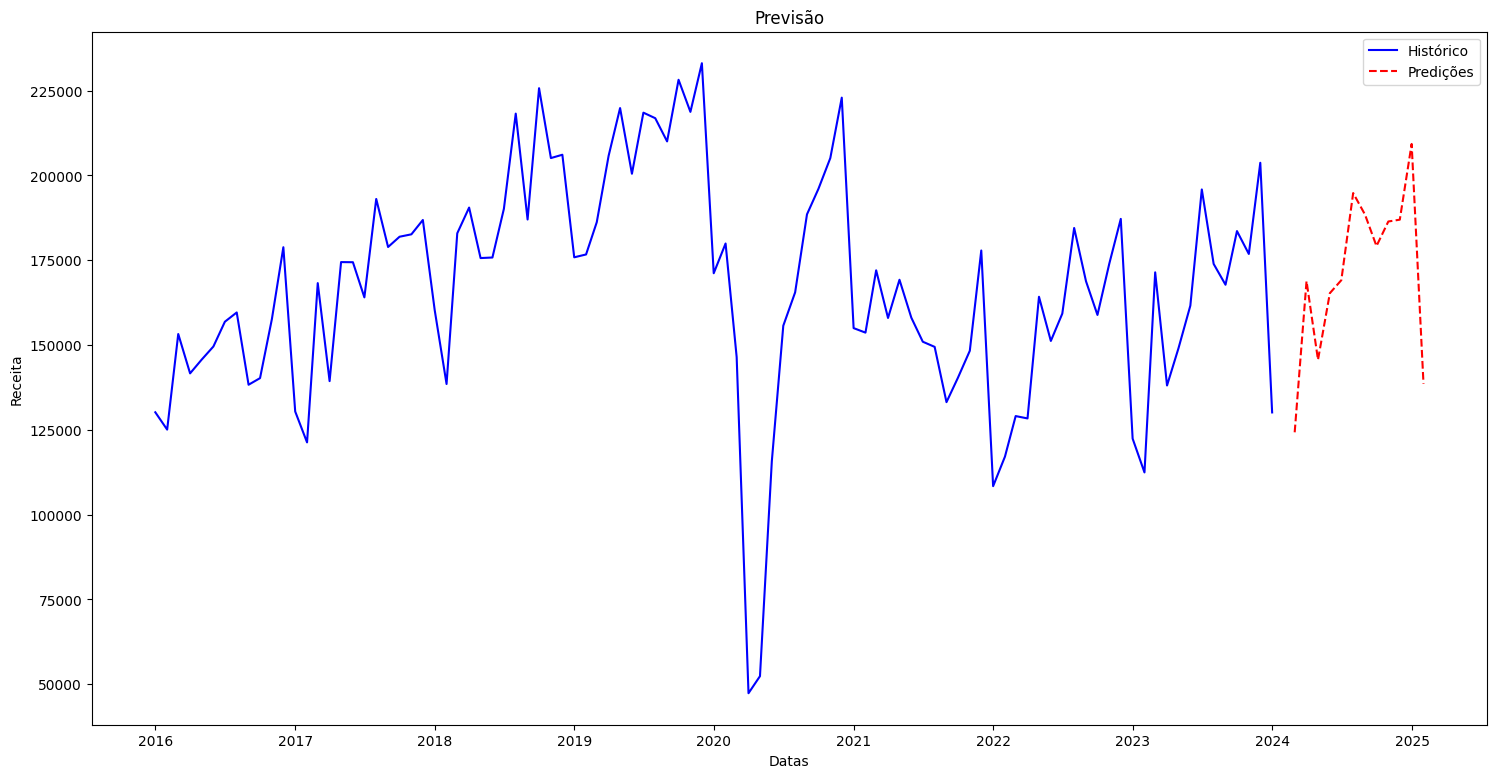

In [84]:
# Plotando os dados históricos e as previsões
plt.figure(figsize=(18, 9))
plt.plot(index, df['populacao'], label='Histórico', color='blue')
plt.plot(forecast_df.index, forecast_df['populacao'], label='Predições', color='red', linestyle='--')
# Adicionando intervalo de confiança

plt.title('Previsão')
plt.xlabel('Datas')
plt.ylabel('Receita')
plt.legend()
plt.show()

In [85]:
forecast_df

,populacao
2024-02,124274.781270
2024-03,168838.456128
2024-04,145637.984738
2024-05,165285.334825
2024-06,169114.003300
2024-07,194790.966550
2024-08,188438.355690
2024-09,179169.400058
2024-10,186410.399380
2024-11,186948.197141


## Conclusão
Mesmo que essa série temporal tenha sazonalidade, a previsão com SARIMAX não teve resultados agradáveis.

## Essa cédula é para salvar o csv com os carros produzidos por mês, mas para o meu caso é interessante ter os carros produzidos por ano!

In [86]:
predict=forecast_df['2024-01':'2024-12'].to_csv('../data/data_predicted/predict_licenciados_nacionais.csv')

## Aqui abaixo é a conversão do arquivo para a somatória dos meses para ter a produção do ano

In [88]:
janeiro = 130132
teste = forecast_df.copy()
teste

,populacao
2024-02,124274.781270
2024-03,168838.456128
2024-04,145637.984738
2024-05,165285.334825
2024-06,169114.003300
2024-07,194790.966550
2024-08,188438.355690
2024-09,179169.400058
2024-10,186410.399380
2024-11,186948.197141


In [89]:
boolean = True
mes_antigo = 0
j = 0
for column in teste.populacao:
    if boolean:
        boolean = False
        column =  column + janeiro
    column = column + mes_antigo
    mes_antigo = column
    teste.populacao.iloc[j] = column
    j = j + 1
    print(column)


254406.78127019462
423245.237398276
568883.222136058
734168.5569615486
903282.5602614589
1098073.526811705
1286511.8825019589
1465681.2825594856
1652091.681939269
1839039.8790807158
2048305.504640976
2186916.8341912148


/tmp/ipykernel_60002/4200945003.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  teste.populacao.iloc[j] = column


In [90]:
teste

,populacao
2024-02,2.544068e+05
2024-03,4.232452e+05
2024-04,5.688832e+05
2024-05,7.341686e+05
2024-06,9.032826e+05
2024-07,1.098074e+06
2024-08,1.286512e+06
2024-09,1.465681e+06
2024-10,1.652092e+06
2024-11,1.839040e+06


In [91]:
predict_teste=teste.to_csv('../data/data_predicted/predict_licenciados_nacionais.csv')